# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](https://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na co najmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blue one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [1]:
from abc import abstractmethod, ABC
from collections.abc import Iterable
from typing import List
import sklearn
import sklearn.model_selection
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert (
            learning_rate < 1
        ), f"Given learning_rate={learning_rate} is larger than 1"
        assert (
            learning_rate > 0
        ), f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

    @staticmethod
    def add_bias(x: np.ndarray):
        batch_size = x.shape[0]
        ones = np.ones((batch_size, 1, 1))
        return np.concatenate((ones, x), axis=1)


class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.x = None
        self.input_size = input_size
        self.output_size = output_size
        # Xavier (Glorot) initialization
        # https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
        a = 1 / np.sqrt(input_size)
        self.weights = np.random.uniform(
            low=-a, high=a, size=(output_size, input_size + 1)
        )

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = Layer.add_bias(x)
        return self.weights @ self.x

    def backward(self, output_error_derivative) -> np.ndarray:
        xt = np.transpose(self.x, axes=[0, 2, 1])
        dW = np.mean(output_error_derivative @ xt, axis=0)
        self.weights -= self._learning_rate * dW
        # dB = np.mean(output_error_derivative, axis=0)
        # self.bias -= self._learning_rate * dB
        err = self.weights.T @ output_error_derivative
        return err[:, 1:, :]  # remove bias


class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.derivative = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        y = np.tanh(x)
        self.derivative = 1 - y**2
        return y

    def backward(self, output_error_derivative) -> np.ndarray:
        return output_error_derivative * self.derivative


class Loss(ABC):
    def __init__(self) -> None:
        pass

    @abstractmethod
    def loss(self, y_hat: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function for a particular x"""
        pass

    @abstractmethod
    def loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function derivative for a particular x and y"""
        pass


def softmax(x: np.ndarray) -> np.ndarray:
    e = np.exp(x)
    s = np.sum(e, axis=(1, 2), keepdims=True)
    return e / s


class SoftMaxCrossEntropyLoss(Loss):
    def __init__(self) -> None:
        super().__init__()

    def loss(self, y_hat: np.ndarray, y: np.ndarray) -> np.ndarray:
        return -np.sum(y * np.log(softmax(y_hat)))

    def loss_derivative(self, y_hat: np.ndarray, y: np.ndarray) -> np.ndarray:
        return y_hat - y


class Network:
    def __init__(self, layers: List[Layer], loss: Loss, learning_rate: float) -> None:
        self.layers = layers
        self.loss = loss
        self.learning_rate = learning_rate
        for layer in layers:
            layer.learning_rate = self.learning_rate

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        for layer in self.layers:
            x = layer.forward(x)
        return softmax(x)

    def fit(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        epochs: int,
        batch_size: int = 1,
    ) -> None:
        """Fit the network to the training data"""
        n = y_train.shape[0]
        batch_count = int(np.ceil(n / batch_size))
        for _ in range(epochs):
            p = np.random.permutation(n)
            x_train = x_train[p]
            y_train = y_train[p]
            x_batches = np.array_split(x_train, batch_count)
            y_batches = np.array_split(y_train, batch_count)
            for x_batch, y_batch in zip(x_batches, y_batches):
                x_batch = x_batch[..., np.newaxis]
                y_batch = y_batch[..., np.newaxis]
                y_hat = self(x_batch)
                grad = self.loss.loss_derivative(y_hat, y_batch)
                for layer in reversed(self.layers):
                    grad = layer.backward(grad)

    def predict(self, x):
        x = np.atleast_3d(x)
        return self(x).squeeze(-1)

In [3]:
from dataclasses import dataclass


@dataclass(frozen=True)
class Hyperparameters:
    inner_size: int = 32
    epochs: int = 100
    batch_size: int = 1
    learning_rate: float = 0.01
    inner_layers: int = 1


@dataclass
class Data:
    x: np.ndarray
    y: np.ndarray


@dataclass
class Dataset:
    train: Data
    test: Data

In [4]:
def prepare_mnist(test_size=0.2, random_state=None) -> Dataset:
    mnist = sklearn.datasets.load_digits()
    xs = mnist.data / 16
    ys = mnist.target
    ys = np.identity(10)[ys]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        xs, ys, test_size=test_size, random_state=random_state
    )
    return Dataset(Data(X_train, y_train), Data(X_test, y_test))

In [5]:
def make_and_train_network(hyperparameters: Hyperparameters, dataset: Dataset):
    input_size = dataset.train.x.shape[1]
    output_size = dataset.train.y.shape[1]
    inner_size = hyperparameters.inner_size
    layers = [FullyConnected(input_size, inner_size), Tanh()]
    for _ in range(hyperparameters.inner_layers):
        layers.extend([FullyConnected(inner_size, inner_size), Tanh()])
    layers.append(FullyConnected(inner_size, output_size))
    network = Network(layers, SoftMaxCrossEntropyLoss(), hyperparameters.learning_rate)
    network.fit(
        dataset.train.x,
        dataset.train.y,
        hyperparameters.epochs,
        hyperparameters.batch_size,
    )
    return network

In [6]:
def correct_predictions_predicate(network: Network, data: Data):
    return np.argmax(network.predict(data.x), axis=1) == np.argmax(data.y, axis=1)

In [7]:
def accuracy(network: Network, data: Data):
    return np.mean(correct_predictions_predicate(network, data))

In [8]:
def test_average_accuracy(hyperparameters, dataset_func=prepare_mnist, n=10):
    datasets = [dataset_func() for _ in range(n)]
    networks = [
        make_and_train_network(hyperparameters, dataset) for dataset in datasets
    ]
    accuracies = np.array(
        [
            accuracy(network, dataset.test)
            for network, dataset in zip(networks, datasets)
        ]
    )
    if n > 1:
        print(
            f"{n} - avg {np.mean(accuracies):.5f} min {np.min(accuracies):.5f} max {np.max(accuracies):.5f} stdev {np.std(accuracies):.5f}"
        )
        u, counts = np.unique(accuracies, return_counts=True)
        plt.scatter(u, counts)
        plt.xticks(u, rotation=-45)
        plt.yticks(np.insert(np.unique(counts), 0, 0))
        plt.show()
    else:
        print(f"{np.mean(accuracies):.5f}")
    return networks, datasets

Szybki test

In [9]:
_ = test_average_accuracy(Hyperparameters(epochs=30), n=1)

0.97500


Rozrzut dokładności jest dosyć duży, najprawdopodobniej zależy od tego czy trudne przypadki znajdą się w zbiorze treningowym czy nie.

10 - avg 0.97806 min 0.96944 max 0.98889 stdev 0.00708


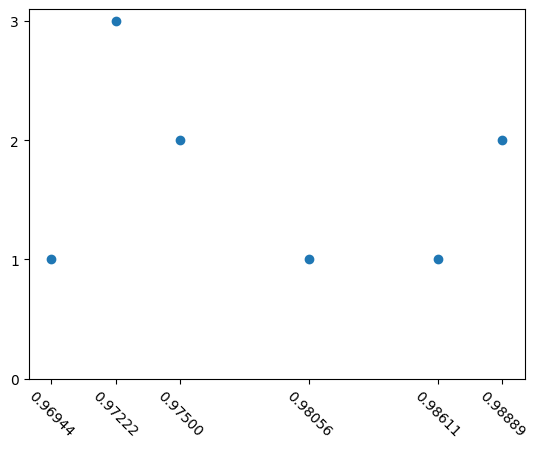

In [10]:
example_networks, example_datasets = test_average_accuracy(Hyperparameters())
best_network, best_dataset = max(
    zip(example_networks, example_datasets), key=lambda nd: accuracy(nd[0], nd[1].test)
)

Trenowanie z mini-batchem trwa mniej czasu (jest mniej propagacji wstecznych), jednak trzeba odpowiednio zwiększyć współczynnik uczenia i/lub liczbę epok. 

10 - avg 0.97556 min 0.95278 max 0.98333 stdev 0.00859


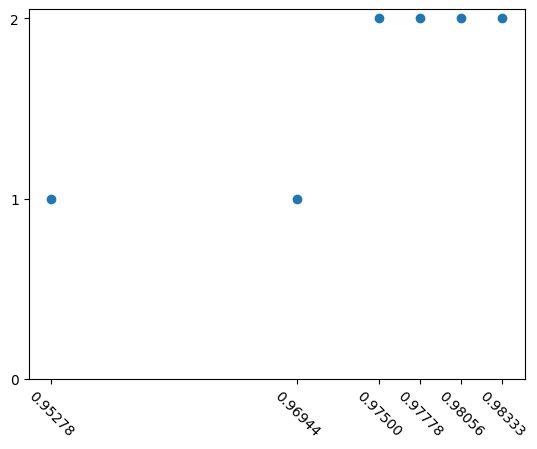

In [11]:
_ = test_average_accuracy(Hyperparameters(batch_size=64, learning_rate=0.64))

In [12]:
def show_incorrect_predictions(network, dataset):
    predictions = network.predict(dataset.test.x)
    predicate = ~correct_predictions_predicate(network, dataset.test)
    print(np.count_nonzero(predicate))
    wrong_cases = dataset.test.x[predicate]
    correct_predictions = dataset.test.y[predicate]
    wrong_predictions = predictions[predicate]
    n = wrong_cases.shape[0]
    width = 4
    height = int(np.ceil(n / width))
    fig, axs = plt.subplots(height, width, squeeze=False)
    for i in range(n, width * height):
        axs[i // width, i % width].axis("off")
    for i, wrong_case, wrong_prediction, correct_prediction in zip(
        range(n), wrong_cases, wrong_predictions, correct_predictions
    ):
        ax = axs[i // width, i % width]
        ax.imshow(np.reshape(wrong_case, (8, 8)), cmap="gray_r")
        ax.set_title(
            f"predicted {np.argmax(wrong_prediction)}, was {np.argmax(correct_prediction)}",
            fontdict={"fontsize": 10},
        )
    plt.tight_layout()
    plt.show() 

Pomyłki najlepszej sieci

4


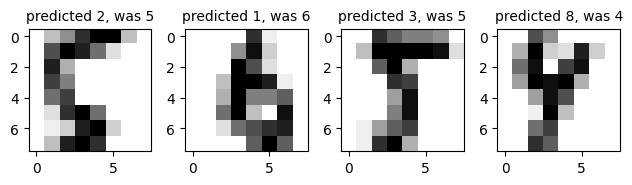

In [13]:
show_incorrect_predictions(best_network, best_dataset)

In [14]:
def test_variable_param(dataset=None, n=10, **kwargs):
    if dataset is None:
        dataset = prepare_mnist()
    iters = [key for key in kwargs if isinstance(kwargs[key], Iterable)]
    assert len(iters) == 1, "Only one iterable allowed in test_variable_param kwargs."
    key = iters[0]
    xs = list(kwargs[key])
    del kwargs[key]
    ys = []
    for x in xs:
        networks = [
            make_and_train_network(Hyperparameters(**{key: x, **kwargs}), dataset)
            for _ in range(n)
        ]
        ys.append(
            np.mean(np.array([accuracy(network, dataset.test) for network in networks]))
        )
    print(f"correlation coefficient {np.corrcoef(xs, ys)[1, 0]:.5f}")
    fig = px.scatter(x=xs, y=ys)
    fig.show()

Szerokość sieci powyżej 32 ma niewielki wpływ na dokładność.

In [15]:
test_variable_param(inner_size=(2**i for i in range(1, 8)))

correlation coefficient 0.44091


Liczba warstw wewnętrznych nie ma większego wpływu na dokładność.

In [16]:
test_variable_param(inner_layers=range(1, 6))

correlation coefficient -0.52597


Po około 30 epokach uzysujemy dobrą dokładność. Dalsze zwiększanie liczby epok nie zmienia dokładności w znaczący sposób.

In [17]:
test_variable_param(n=1, epochs=range(10, 310, 10))

correlation coefficient 0.55913


In [18]:
test_variable_param(n=1, epochs=range(1, 11))

correlation coefficient 0.70283


In [19]:
def prepare_xor(gap=0.01):
    xs = np.random.uniform(size=(1000, 2))
    xs = xs[np.all((xs < 0.5 - gap / 2) | (xs > 0.5 + gap / 2), axis=1)]
    ys = 1 * np.logical_xor(xs[:, 0] > 0.5, xs[:, 1] > 0.5)
    ys = np.identity(2)[ys]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        xs, ys, test_size=0.2, random_state=0
    )
    return Dataset(Data(X_train, y_train), Data(X_test, y_test))

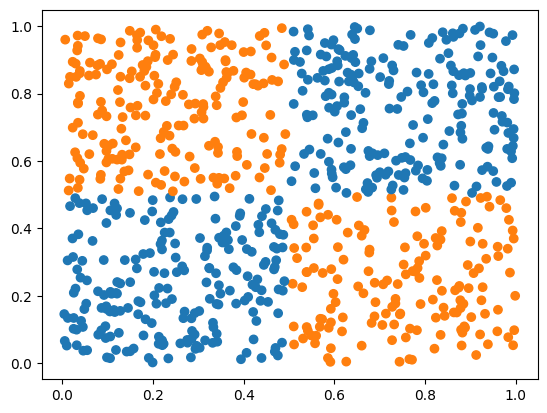

In [20]:
xor = prepare_xor()
plt.scatter(
    xor.train.x[:, 0],
    xor.train.x[:, 1],
    c=np.array(["C0", "C1"])[np.argmax(xor.train.y, axis=1)],
)
plt.show()

In [21]:
test_variable_param(dataset=xor, n=1, epochs=100, inner_size=(2**i for i in range(1, 8)))

correlation coefficient 0.33460


In [22]:
def show_network(network):
    X = np.arange(0, 1, 0.01)
    Y = np.arange(0, 1, 0.01)
    C = np.array([[x, y] for x in X for y in Y])[..., np.newaxis]
    Z = network(C).squeeze(-1)
    Z = Z[:, 1]
    Z = Z.reshape(X.shape[0], X.shape[0])
    fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z)])
    fig.add_scatter3d(x=X, y=Y, z=np.ones_like(Z))
    fig.update_layout(autosize=False, width=1280, height=720)
    fig.show()

In [23]:
def train_and_show_xor(hyperparameters=None, cond=lambda n, d: True):
    network = make_and_train_network(hyperparameters, xor)
    if cond(network, xor):
        print(f"Train accuracy {accuracy(network, xor.train)}")
        print(f"Test accuracy {accuracy(network, xor.test)}")
        show_network(network)
    return network, xor

In [24]:
_ = train_and_show_xor(Hyperparameters(inner_size=16, epochs=100))

Train accuracy 0.9795918367346939
Test accuracy 0.9847715736040609


Szerokość nadal nie ma wpływu na poprawność

In [25]:
_ = train_and_show_xor(Hyperparameters(inner_size=128, epochs=100))

Train accuracy 0.9655612244897959
Test accuracy 0.9746192893401016


# Zanikanie gradientu

Już przy 5 warstwach wewnętrznych, podobnie jak w:
1. https://machinelearningmastery.com/how-to-fix-vanishing-gradients-using-the-rectified-linear-activation-function/
2. https://neuralnetworksanddeeplearning.com/chap5.html

In [26]:
_ = train_and_show_xor(Hyperparameters(inner_layers=4, epochs=100))

Train accuracy 0.9489795918367347
Test accuracy 0.9796954314720813


In [27]:
while True:
    cond = lambda n, d: accuracy(n, d.train) < 0.6 
    n, d = train_and_show_xor(Hyperparameters(inner_layers=5, epochs=100), cond=cond)
    if cond(n, d):
        break

Train accuracy 0.45663265306122447
Test accuracy 0.49238578680203043


In [28]:
while True:
    cond = lambda n, d: accuracy(n, d.train) > 0.9 
    n, d = train_and_show_xor(Hyperparameters(inner_layers=5, epochs=100), cond=cond)
    if cond(n, d):
        break

Train accuracy 0.9451530612244898
Test accuracy 0.949238578680203
